Ensemble Model

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


Load predictions and actuals dataframe

In [8]:
import os
import pandas as pd
from pathlib import Path
# Set the working directory
project_dir = Path(os.getcwd()).parent

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'results' 

# Function to load predictions with lag/lead structure
def load_predictions(file_name):
    df = pd.read_csv(data_dir / file_name)
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index('date')

# Load predictions from different models
midas_predictions = load_predictions('midas.csv')
lstm_predictions = load_predictions('lstm.csv')
elastic_net_predictions = load_predictions('elastic_net.csv')
dfm_mq_predictions = load_predictions('dfm_mq.csv')  # Added DFM-MQ predictions

# Load true target values
true_values = pd.read_csv(data_dir / 'actuals.csv')
true_values['date'] = pd.to_datetime(true_values['date'])
true_values = true_values.set_index('date')

# Create a list of all unique dates
all_dates = sorted(set(midas_predictions.index) | 
                   set(lstm_predictions.index) | 
                   set(elastic_net_predictions.index) | 
                   set(dfm_mq_predictions.index) |  # Added DFM-MQ to the set
                   set(true_values.index))

# Create an empty DataFrame with all dates
ensemble_data = pd.DataFrame(index=all_dates)

# Add predictions from each model for each lag/lead
for col in midas_predictions.columns:
    ensemble_data[f'midas_{col}'] = midas_predictions[col]

for col in lstm_predictions.columns:
    ensemble_data[f'lstm_{col}'] = lstm_predictions[col]

for col in elastic_net_predictions.columns:
    ensemble_data[f'elastic_net_{col}'] = elastic_net_predictions[col]

for col in dfm_mq_predictions.columns:  # Added DFM-MQ predictions
    ensemble_data[f'dfm_mq_{col}'] = dfm_mq_predictions[col]

# Add true values
ensemble_data['target'] = true_values['actuals']

# Sort the index and reset it
ensemble_data = ensemble_data.sort_index().reset_index()

# Rename the 'index' column to 'date'
ensemble_data = ensemble_data.rename(columns={'index': 'date'})

# Print the first few rows to verify
print(ensemble_data.tail())

# Save the ensemble data to a CSV file
ensemble_data.to_csv(data_dir / 'ensemble_data.csv', index=False)
print("Ensemble data saved to 'ensemble_data.csv'")

/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_72704/3869255208.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_72704/3869255208.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])
/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_72704/3869255208.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  true_values['date'] = pd.to_datetime(true_values['date'])


         date   midas_0   midas_1   midas_2   midas_3    lstm_0    lstm_1  \
73 2024-02-29       NaN       NaN       NaN       NaN       NaN       NaN   
74 2024-03-31 -0.804221 -0.795951 -0.852269 -0.851360 -1.185707 -0.419037   
75 2024-04-30       NaN       NaN       NaN       NaN       NaN       NaN   
76 2024-05-31       NaN       NaN       NaN       NaN       NaN       NaN   
77 2024-06-30  0.172783  0.282599  0.154622  0.156397  0.121169  0.099065   

      lstm_2    lstm_3  elastic_net_0  elastic_net_1  elastic_net_2  \
73       NaN       NaN            NaN            NaN            NaN   
74 -0.220745  0.170822      -1.181358      -1.177902      -1.177901   
75       NaN       NaN            NaN            NaN            NaN   
76       NaN       NaN            NaN            NaN            NaN   
77  0.308880  0.395461       0.125677       0.137014       0.270172   

    elastic_net_3  dfm_mq_0  dfm_mq_1  dfm_mq_2  dfm_mq_3    target  
73            NaN       NaN       NaN   

Simple average

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Calculate average predictions for each lag
for lag in all_lags:
    lag_cols = [col for col in ensemble_data.columns if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'avg_{lag}'] = ensemble_data[lag_cols].mean(axis=1)

# Calculate overall simple average across all lags
avg_columns = [f'avg_{lag}' for lag in all_lags]
ensemble_data['simple_avg'] = ensemble_data[avg_columns].mean(axis=1)

# Calculate performance of simple averaging
# First, remove any rows where target or simple_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'simple_avg'])

mse_avg = mean_squared_error(valid_data['target'], valid_data['simple_avg'])
mae_avg = mean_absolute_error(valid_data['target'], valid_data['simple_avg'])
rmse_avg = np.sqrt(mse_avg)

print(f"Simple Averaging - MSE: {mse_avg}, MAE: {mae_avg}, RMSE: {rmse_avg}")

# Optional: Calculate and print performance for each lag
for lag in all_lags:
    lag_col = f'avg_{lag}'
    if lag_col in valid_data.columns:
        mse = mean_squared_error(valid_data['target'], valid_data[lag_col])
        mae = mean_absolute_error(valid_data['target'], valid_data[lag_col])
        rmse = np.sqrt(mse)
        print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")


Simple Averaging - MSE: 0.313026719853232, MAE: 0.40363159227760204, RMSE: 0.5594879085853706
Lag 0 - MSE: 0.16045892690242594, MAE: 0.31383536456035327, RMSE: 0.40057324786164383
Lag 1 - MSE: 0.2935959102810726, MAE: 0.37669491522998066, RMSE: 0.5418449134956169
Lag 2 - MSE: 0.40324434592449787, MAE: 0.444609134308382, RMSE: 0.6350152328287078
Lag 3 - MSE: 0.5109558274461949, MAE: 0.4944477727854578, RMSE: 0.7148117426610974


Weighted average

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Calculate MSE for each model and lag
mse_dict = {}
for lag in all_lags:
    for model in ['midas', 'lstm', 'elastic_net', "dfm_mq"]:
        col = f'{model}_{lag}'
        if col in ensemble_data.columns:
            # Ensure we're only using rows where both target and prediction are non-null
            valid_data = ensemble_data.dropna(subset=['target', col])
            if len(valid_data) > 0:
                mse = mean_squared_error(valid_data['target'], valid_data[col])
                mse_dict[col] = mse

# Calculate inverse error weights
weights = {col: 1/mse for col, mse in mse_dict.items()}

# Normalize weights so they sum to 1
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

# Calculate weighted average predictions for each lag
for lag in all_lags:
    lag_cols = [col for col in weights.keys() if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'weighted_avg_{lag}'] = sum(ensemble_data[col] * weights[col] for col in lag_cols)

# Calculate overall weighted average across all lags
weighted_avg_columns = [f'weighted_avg_{lag}' for lag in all_lags if f'weighted_avg_{lag}' in ensemble_data.columns]
ensemble_data['weighted_avg'] = ensemble_data[weighted_avg_columns].mean(axis=1)

# Calculate performance of weighted averaging
# First, remove any rows where target or weighted_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'weighted_avg'])

if len(valid_data) > 0:
    mse_weighted = mean_squared_error(valid_data['target'], valid_data['weighted_avg'])
    mae_weighted = mean_absolute_error(valid_data['target'], valid_data['weighted_avg'])
    rmse_weighted = np.sqrt(mse_weighted)

    print(f"Weighted Averaging - MSE: {mse_weighted}, MAE: {mae_weighted}, RMSE: {rmse_weighted}")

    # Optional: Calculate and print performance for each lag
    for lag in all_lags:
        lag_col = f'weighted_avg_{lag}'
        if lag_col in valid_data.columns:
            lag_valid_data = valid_data.dropna(subset=['target', lag_col])
            if len(lag_valid_data) > 0:
                mse = mean_squared_error(lag_valid_data['target'], lag_valid_data[lag_col])
                mae = mean_absolute_error(lag_valid_data['target'], lag_valid_data[lag_col])
                rmse = np.sqrt(mse)
                print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
else:
    print("No valid data available for performance calculation.")


Weighted Averaging - MSE: 0.7231222673044334, MAE: 0.6313826803313911, RMSE: 0.85036596081007
Lag 0 - MSE: 0.64670334272269, MAE: 0.6002891088188396, RMSE: 0.804178675869169
Lag 1 - MSE: 0.7038493059035494, MAE: 0.6215029034242832, RMSE: 0.8389572729904363
Lag 2 - MSE: 0.7397788638901833, MAE: 0.6370850548051641, RMSE: 0.8601039843473481
Lag 3 - MSE: 0.8077083610141915, MAE: 0.6666536542772774, RMSE: 0.8987259654723411


Dynamic weighting

In [11]:
# Define a function to compute exponentially weighted moving average (EWMA)
def compute_ewma(data, alpha=0.5):
    return data.ewm(alpha=alpha).mean()

# Apply EWMA to errors before calculating weights
error_dict = {}
for lag in all_lags:
    for model in ['midas', 'lstm', 'elastic_net', 'dfm_mq']:
        col = f'{model}_{lag}'
        if col in ensemble_data.columns:
            error_dict[col] = compute_ewma((ensemble_data['target'] - ensemble_data[col]) ** 2)

# Calculate inverse error weights based on EWMA of errors
weights = {col: 1/error.iloc[-1] for col, error in error_dict.items()}

# Normalize weights so they sum to 1
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

# Calculate weighted average predictions for each lag
for lag in all_lags:
    lag_cols = [col for col in weights.keys() if col.endswith(f'_{lag}')]
    if lag_cols:
        ensemble_data[f'ewma_weighted_avg_{lag}'] = sum(ensemble_data[col] * weights[col] for col in lag_cols)

# Calculate overall weighted average across all lags
ewma_weighted_avg_columns = [f'ewma_weighted_avg_{lag}' for lag in all_lags if f'ewma_weighted_avg_{lag}' in ensemble_data.columns]
ensemble_data['ewma_weighted_avg'] = ensemble_data[ewma_weighted_avg_columns].mean(axis=1)

# Calculate performance of EWMA weighted averaging
# First, remove any rows where target or ewma_weighted_avg is NaN
valid_data = ensemble_data.dropna(subset=['target', 'ewma_weighted_avg'])

if len(valid_data) > 0:
    mse_ewma_weighted = mean_squared_error(valid_data['target'], valid_data['ewma_weighted_avg'])
    mae_ewma_weighted = mean_absolute_error(valid_data['target'], valid_data['ewma_weighted_avg'])
    rmse_ewma_weighted = np.sqrt(mse_ewma_weighted)

    print(f"EWMA Weighted Averaging - MSE: {mse_ewma_weighted}, MAE: {mae_ewma_weighted}, RMSE: {rmse_ewma_weighted}")

    # Optional: Calculate and print performance for each lag
    for lag in all_lags:
        lag_col = f'ewma_weighted_avg_{lag}'
        if lag_col in valid_data.columns:
            lag_valid_data = valid_data.dropna(subset=['target', lag_col])
            if len(lag_valid_data) > 0:
                mse = mean_squared_error(lag_valid_data['target'], lag_valid_data[lag_col])
                mae = mean_absolute_error(lag_valid_data['target'], lag_valid_data[lag_col])
                rmse = np.sqrt(mse)
                print(f"Lag {lag} - MSE: {mse}, MAE: {mae}, RMSE: {rmse}")
else:
    print("No valid data available for EWMA performance calculation.")

# Update the mse_dict for the best model selection
mse_dict['EWMA Weighted Averaging'] = {lag: mean_squared_error(valid_data['target'], valid_data[f'ewma_weighted_avg_{lag}']) 
                                       for lag in all_lags if f'ewma_weighted_avg_{lag}' in valid_data.columns}


EWMA Weighted Averaging - MSE: 0.7271263816570513, MAE: 0.6337245558287767, RMSE: 0.852717058382821
Lag 0 - MSE: 0.6941940573857311, MAE: 0.6244128357535925, RMSE: 0.8331830875538287
Lag 1 - MSE: 0.7496088376666754, MAE: 0.6433968248818404, RMSE: 0.8657995366519177
Lag 2 - MSE: 0.6004469317007515, MAE: 0.566693829305887, RMSE: 0.7748851087101568
Lag 3 - MSE: 0.8803264727371101, MAE: 0.7003947333737867, RMSE: 0.9382571463821152


Model stacking

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Identify all unique lags across all models
all_lags = set()
for col in ensemble_data.columns:
    if '_' in col and col.split('_')[1].lstrip('-').isdigit():
        all_lags.add(col.split('_')[1])

# Sort lags to ensure consistent order
all_lags = sorted(all_lags, key=lambda x: int(x))

# Function to get common dates
def get_common_dates(data, columns):
    return data.dropna(subset=columns).index

# Get common dates across all columns (including target and all model predictions)
columns_to_check = ['target'] + [f'{model}_{lag}' for model in ['midas', 'lstm', 'elastic_net', 'dfm_mq'] for lag in all_lags]
common_dates = get_common_dates(ensemble_data, columns_to_check)

# Filter data to only include common dates
filtered_data = ensemble_data.loc[common_dates]

# Dictionary to store stacked predictions for each lag
stacking = {}

# Perform stacking for each lag using past data only, starting from the second available date
for lag in all_lags:
    # Prepare data for this lag
    X_lag = filtered_data[[f'{model}_{lag}' for model in ['midas', 'lstm', 'elastic_net', 'dfm_mq']]]
    y_lag = filtered_data['target']
    
    stacking_predictions = []
    
    # Loop through each time point, starting from the second available date
    for i in range(1, len(X_lag)):
        # Split the data so that the training set includes all data before the current time point
        X_train = X_lag.iloc[:i]
        y_train = y_lag.iloc[:i]
        
        # Use ElasticNet as the meta-model
        meta_model = ElasticNet(alpha=0.01, l1_ratio=0.4, max_iter=100000, tol=1e-6)  # Tune alpha and l1_ratio as needed
        meta_model.fit(X_train, y_train)
        
        # Predict the current value
        stacking_predictions.append(meta_model.predict(X_lag.iloc[[i]])[0])
    
    # Fill the first prediction with NaN (or any other placeholder)
    stacking[lag] = np.array([np.nan] + stacking_predictions)
    
    # Calculate performance for this lag, ignoring NaNs
    valid_idx = ~np.isnan(stacking[lag])
    mse_stacking = mean_squared_error(y_lag[valid_idx], stacking[lag][valid_idx])
    mae_stacking = mean_absolute_error(y_lag[valid_idx], stacking[lag][valid_idx])
    rmse_stacking = np.sqrt(mse_stacking)
    
    print(f"Stacking for lag {lag} - MSE: {mse_stacking}, MAE: {mae_stacking}, RMSE: {rmse_stacking}")
    
    # Optional: Print feature importances for this lag
    if len(X_train) > 0:  # Print feature importances only if the model was trained
        feature_importance = pd.DataFrame({
            'feature': X_lag.columns,
            'importance': np.abs(meta_model.coef_)
        })
        feature_importance = feature_importance.sort_values('importance', ascending=False)
        print(f"\nFeature Importances for lag {lag}:")
        print(feature_importance)
        print("\n")

# Add stacked predictions to the filtered_data DataFrame
for lag, predictions in stacking.items():
    filtered_data[f'stacked_prediction_{lag}'] = predictions

# Calculate overall stacked prediction (e.g., average of all lag predictions)
filtered_data['overall_stacked_prediction'] = filtered_data[[f'stacked_prediction_{lag}' for lag in all_lags]].mean(axis=1)

# Calculate overall performance, ignoring NaNs
valid_idx_overall = ~np.isnan(filtered_data['overall_stacked_prediction'])
mse_overall = mean_squared_error(filtered_data['target'][valid_idx_overall], filtered_data['overall_stacked_prediction'][valid_idx_overall])
mae_overall = mean_absolute_error(filtered_data['target'][valid_idx_overall], filtered_data['overall_stacked_prediction'][valid_idx_overall])
rmse_overall = np.sqrt(mse_overall)

print(f"Overall Stacking Performance - MSE: {mse_overall}, MAE: {mae_overall}, RMSE: {rmse_overall}")

# Update mse_dict for Stacking
mse_dict['Stacking'] = {lag: mean_squared_error(filtered_data['target'][valid_idx], filtered_data[f'stacked_prediction_{lag}'][valid_idx]) for lag in all_lags}


Stacking for lag 0 - MSE: 0.2866031654117356, MAE: 0.2670856585600361, RMSE: 0.5353533089574917

Feature Importances for lag 0:
         feature  importance
0        midas_0    1.107300
2  elastic_net_0    0.261983
1         lstm_0    0.257773
3       dfm_mq_0    0.174233


Stacking for lag 1 - MSE: 0.10620429171233318, MAE: 0.23287775894875348, RMSE: 0.3258899994052183

Feature Importances for lag 1:
         feature  importance
0        midas_1    0.884258
2  elastic_net_1    0.735759
3       dfm_mq_1    0.137107
1         lstm_1    0.018435


Stacking for lag 2 - MSE: 0.10808496969623795, MAE: 0.2271902506134912, RMSE: 0.32876278636159223

Feature Importances for lag 2:
         feature  importance
0        midas_2    0.890691
2  elastic_net_2    0.708366
3       dfm_mq_2    0.293388
1         lstm_2    0.000000


Stacking for lag 3 - MSE: 0.21537883096968058, MAE: 0.3004428979934682, RMSE: 0.4640892489270578

Feature Importances for lag 3:
         feature  importance
0        mida

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Ensemble model selection

Columns in filtered_data:
Index(['date', 'midas_0', 'midas_1', 'midas_2', 'midas_3', 'lstm_0', 'lstm_1',
       'lstm_2', 'lstm_3', 'elastic_net_0', 'elastic_net_1', 'elastic_net_2',
       'elastic_net_3', 'dfm_mq_0', 'dfm_mq_1', 'dfm_mq_2', 'dfm_mq_3',
       'target', 'avg_0', 'avg_1', 'avg_2', 'avg_3', 'simple_avg',
       'weighted_avg_0', 'weighted_avg_1', 'weighted_avg_2', 'weighted_avg_3',
       'weighted_avg', 'ewma_weighted_avg_0', 'ewma_weighted_avg_1',
       'ewma_weighted_avg_2', 'ewma_weighted_avg_3', 'ewma_weighted_avg',
       'stacked_prediction_0', 'stacked_prediction_1', 'stacked_prediction_2',
       'stacked_prediction_3', 'overall_stacked_prediction'],
      dtype='object')

Processing lag 0:
  Simple Average column found: avg_0
  Weighted Average column found: weighted_avg_0
  EWMA Weighted Average column found: ewma_weighted_avg_0
  Stacking column found: stacked_prediction_0

Processing lag 1:
  Simple Average column found: avg_1
  Weighted Average column fou

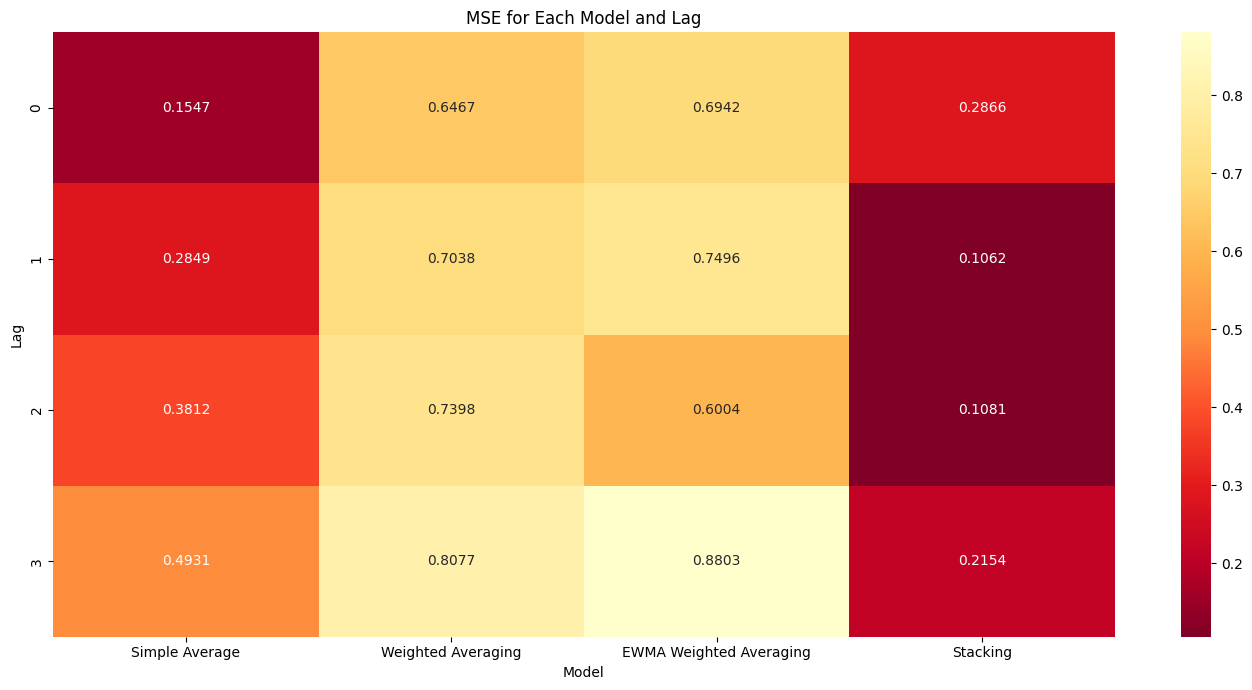

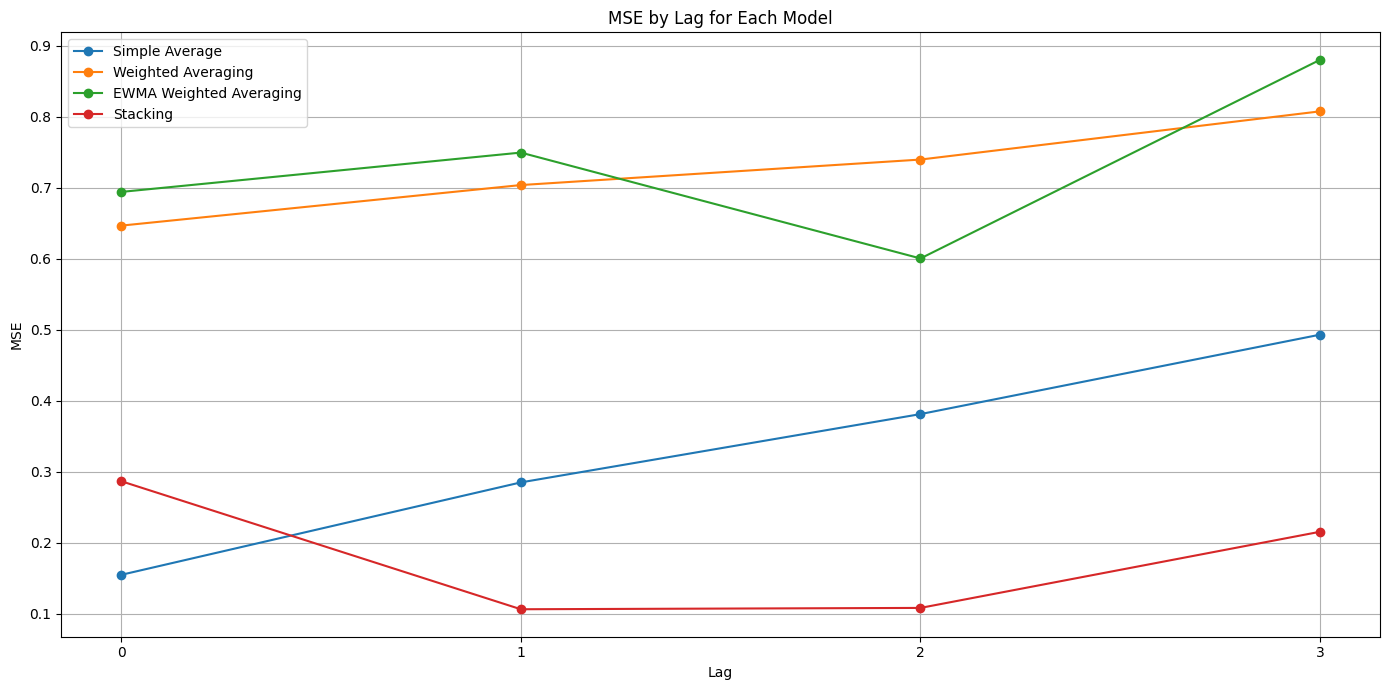


Overall performance (average MSE across all lags):
Simple Average: 0.3285
Weighted Averaging: 0.7245
EWMA Weighted Averaging: 0.7311
Stacking: 0.1791

Best overall method: Stacking (Average MSE: 0.1791)


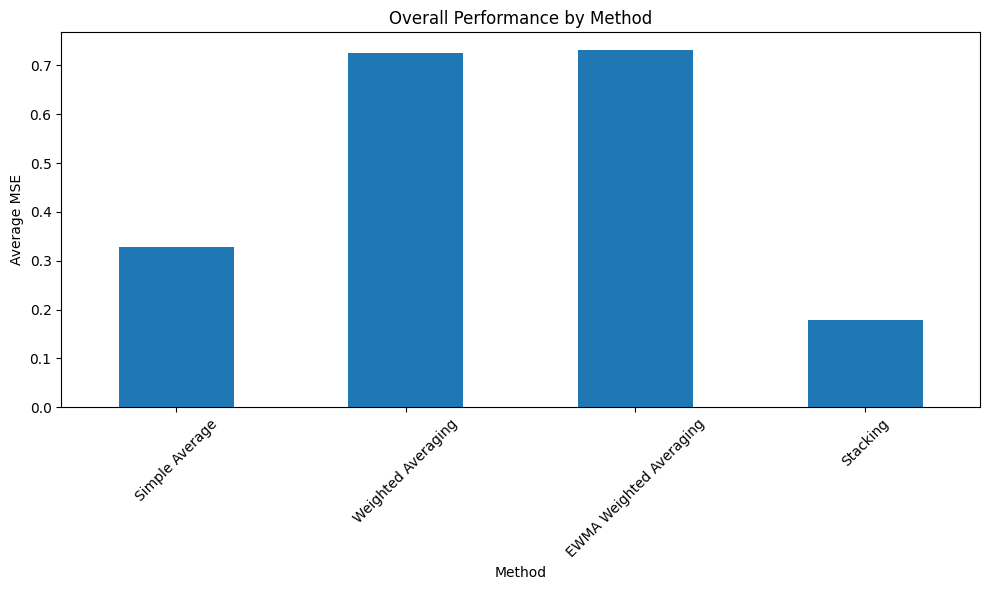

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Update the methods list to include all the models we've implemented
methods = ['Simple Average', 'Weighted Averaging', 'EWMA Weighted Averaging', 'Stacking']

# Create a dictionary to store MSE values for each method and lag
mse_dict = {method: {} for method in methods}

# Print column names for debugging
print("Columns in filtered_data:")
print(filtered_data.columns)


# Calculate MSE for each method and lag
for lag in all_lags:
    print(f"\nProcessing lag {lag}:")
    
    # Simple Average
    col_name = f'avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['Simple Average'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  Simple Average column found: {col_name}")
    else:
        print(f"  Simple Average column not found: {col_name}")
    
    # Weighted Average
    col_name = f'weighted_avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['Weighted Averaging'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  Weighted Average column found: {col_name}")
    else:
        print(f"  Weighted Average column not found: {col_name}")
    
    # EWMA Weighted Average
    col_name = f'ewma_weighted_avg_{lag}'
    if col_name in filtered_data.columns:
        mse_dict['EWMA Weighted Averaging'][lag] = mean_squared_error(filtered_data['target'], filtered_data[col_name])
        print(f"  EWMA Weighted Average column found: {col_name}")
    else:
        print(f"  EWMA Weighted Average column not found: {col_name}")
    
    # Stacking
    col_name = f'stacked_prediction_{lag}'
    if col_name in filtered_data.columns:
        # Handle NaN values before calculating MSE
        target = filtered_data['target'].dropna()
        predictions = filtered_data[col_name].dropna()
        
        # Ensure both arrays have the same length after dropping NaNs
        common_index = target.index.intersection(predictions.index)
        target = target.loc[common_index]
        predictions = predictions.loc[common_index]
        
        if len(target) > 0 and len(predictions) > 0:
            mse_dict['Stacking'][lag] = mean_squared_error(target, predictions)
            print(f"  Stacking column found: {col_name}")
        else:
            print(f"  Stacking column found: {col_name}, but no valid data after removing NaNs")
    else:
        print(f"  Stacking column not found: {col_name}")

# Create a DataFrame from the MSE dictionary
mse_df = pd.DataFrame(mse_dict)

# Print the MSE DataFrame for debugging
print("\nMSE DataFrame:")
print(mse_df)

# Find the best model for each lag
best_models = mse_df.idxmin(axis=1)
best_mse = mse_df.min(axis=1)

# Print the best model for each lag
print("\nBest model for each lag:")
for lag, model in best_models.items():
    print(f"Lag {lag}: {model} (MSE: {best_mse[lag]:.4f})")

# Visualize the performance
plt.figure(figsize=(14, 7))
sns.heatmap(mse_df, annot=True, fmt='.4f', cmap='YlOrRd_r')
plt.title('MSE for Each Model and Lag')
plt.xlabel('Model')
plt.ylabel('Lag')
plt.tight_layout()
plt.show()

# Line plot of MSE for each model across lags
plt.figure(figsize=(14, 7))
for method in methods:
    if method in mse_df.columns:
        plt.plot(mse_df.index, mse_df[method], marker='o', label=method)
plt.title('MSE by Lag for Each Model')
plt.xlabel('Lag')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate overall performance for each method
overall_performance = mse_df.mean()
print("\nOverall performance (average MSE across all lags):")
for method, mse in overall_performance.items():
    print(f"{method}: {mse:.4f}")

# Identify the best overall method
best_overall_method = overall_performance.idxmin()
best_overall_mse = overall_performance.min()
print(f"\nBest overall method: {best_overall_method} (Average MSE: {best_overall_mse:.4f})")

# Bar plot of overall performance
plt.figure(figsize=(10, 6))
overall_performance.plot(kind='bar')
plt.title('Overall Performance by Method')
plt.xlabel('Method')
plt.ylabel('Average MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

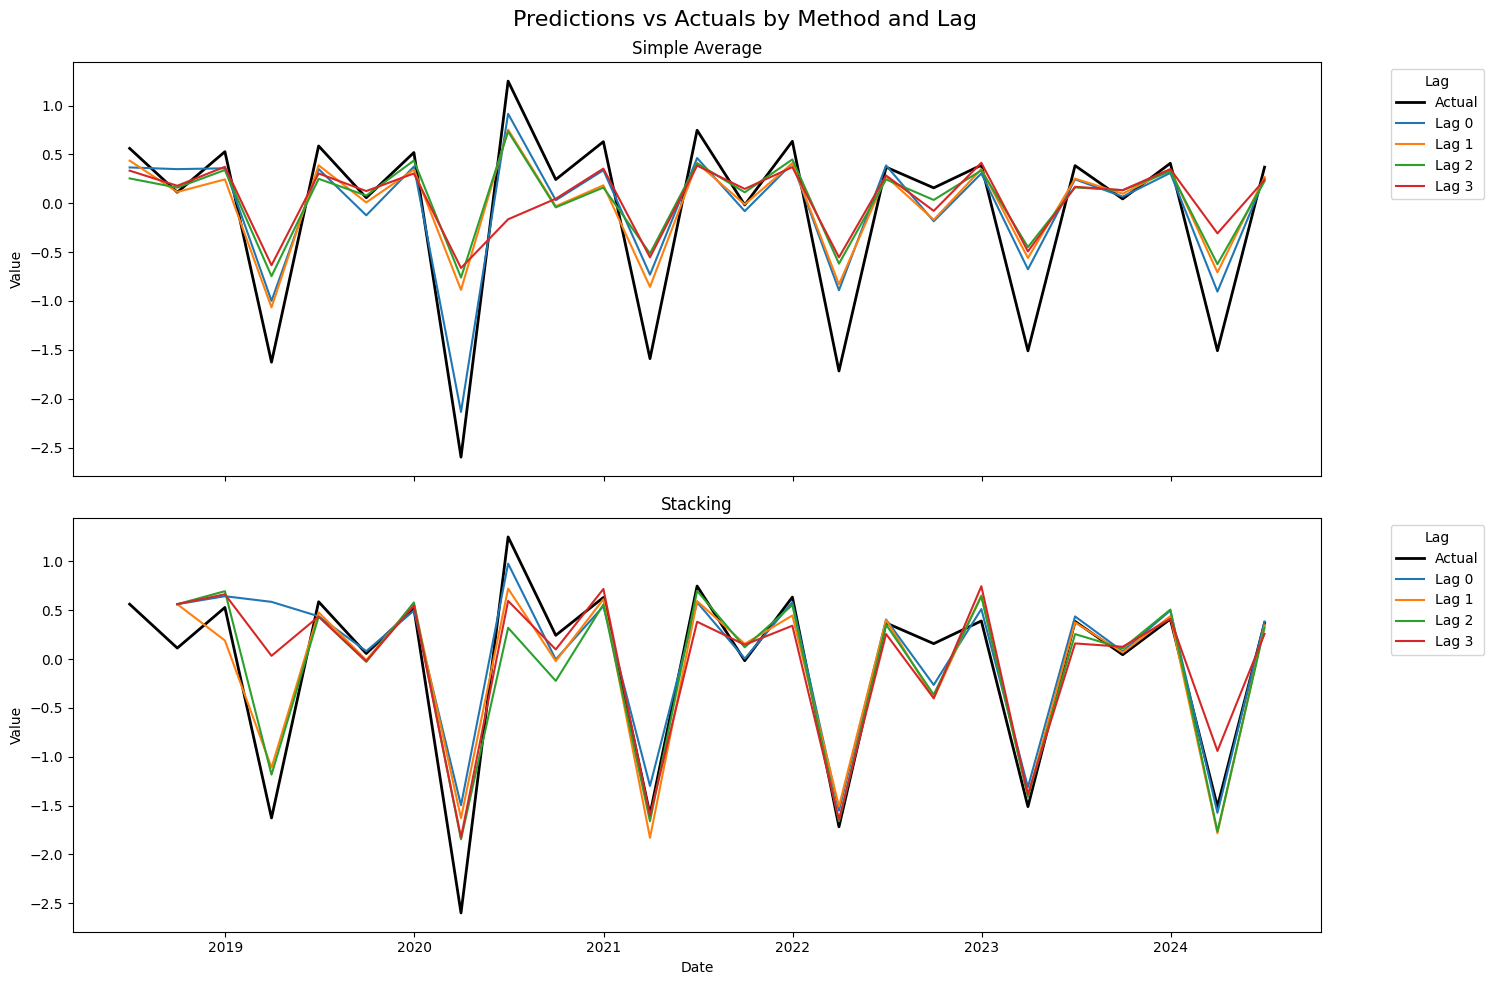

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'filtered_data' contains your predictions and actuals

# Create a new DataFrame for plotting
plot_data = filtered_data[['date', 'target']].copy()

# Define methods and lags
methods = ['avg', 'stacked_prediction']
method_names = ['Simple Average', 'Stacking']

# Set up the plot
fig, axes = plt.subplots(len(methods), 1, figsize=(15, 5*len(methods)), sharex=True)
fig.suptitle('Predictions vs Actuals by Method and Lag', fontsize=16)

for i, (method, method_name) in enumerate(zip(methods, method_names)):
    # Plot actual values
    sns.lineplot(data=plot_data, x='date', y='target', ax=axes[i], label='Actual', color='black', linewidth=2)
    
    # Plot predictions for each lag
    for lag in all_lags:
        column_name = f'{method}_{lag}'
        if column_name in filtered_data.columns:
            sns.lineplot(data=filtered_data, x='date', y=column_name, ax=axes[i], label=f'Lag {lag}')
    
    axes[i].set_title(method_name)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')
    axes[i].legend(title='Lag', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



Save result

In [18]:
# Save the final ensemble predictions
ensemble_data.to_csv('final_ensemble_predictions.csv', index=False)

# If stacking is the best model, you might want to save the meta-model
import joblib
joblib.dump(meta_model, 'stackedmeta_model.pkl')


['stacked_meta_model.pkl']